In [74]:
# from transformers import pipeline
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [17]:
with open("/Users/scampione/Downloads/subset_philly_businesses_with_photos/part-00000-e2c95edc-e5eb-41cd-8a33-3baf4320fd9c-c000.csv") as file:
    lines = file.readlines()

In [22]:
split_lines = [line.split(',') for line in lines]

cleaned_lines = [[bid, pid.strip()] for bid, pid in split_lines]
cleaned_lines[0:5]

[['EtKSTHV5Qx_Q7Aur9o4kQQ', 'gvfHaKjSKf3xQTTzqqUL2w'],
 ['Sp-LM7L_6M-MPo5NCHw8Og', '1aZ1Ae0vmsjgvSIMdrvlzA'],
 ['jcJAFarKwZCrDMomXdcz-Q', '-d3VfOmBHGrWW9ZH7ad8Vw'],
 ['Ou-_OQUNvBcaAoRU0XPtaQ', 'iyKbQecKjfVoR17UAuHxdg'],
 ['HkhqlX-GOrm96yvG3wHZqw', 'UybJ2JaGGoIbGooAz8sNgg']]

In [27]:
d=dict()
for bid, pid in cleaned_lines:
    if bid not in d:
        d[bid] = [pid]
    else:        
        d[bid].append(pid)

In [42]:
d

{'EtKSTHV5Qx_Q7Aur9o4kQQ': ['gvfHaKjSKf3xQTTzqqUL2w',
  'ybKHIZVzqCwc2y7VZ-R6zw',
  'MLjVBML4TSd8JaYmReO5bA',
  '_hJndwm5Lfr_RaaccDHW7g',
  'DtyK_6rTTJuKDm0J-QQ7zw',
  '_YuyUpbJw2XXO9sqUWkBbg',
  '0BVrzoYoGp76kZI23ivI0A',
  '6G_GF9nmfFQlbSwFGqBePQ',
  'uMRM9peN-kk2OvwLqVEJYA',
  'xwJl5he3cuYQmF_PikFezg',
  'xIFMzIoGMdZLDAvNgd-Jbg',
  'FTLjIUEVvhHYVSIB3RC_Nw',
  'W3XdxXRN671Odmin4RW4SA',
  'a_J6u60MNMO94R_NlOQdNg',
  '11q03EyLfzHri3SCRWUz1Q',
  'epXCFjdYDgoihf6n-jAPYw',
  'VMkKydbuoYxZjJfDi8N1ew',
  'GqddXKJZ-K6dPBl_jRiAgw',
  'qwr2_xVJWtCFJTpl_m8_Gw',
  'yGb9wLsjqCm79mjUs_7iAQ',
  'LXbTezpmcCkhpdJ4CEAnag',
  'n-XfyKYtdyeCQXoAUn0iNA',
  'SnWnX_cqhCVmnGhes9pLmA',
  'mMK4TW-UynouyMesPjuCag',
  'KC-8O_YYzTuiBxUopG-lfQ',
  '2cdJ0dxpxy_5Ww4a0AIoEw',
  '_V6EU1NKwRYy7ASrgjZCEg',
  '_u1mzRyewTHSXGM_MuQcwA',
  '13XHMnqlTkiCrVoJyED1vQ',
  '4p27q1DvjwBh0rtfl1yXOA',
  's0_cfiDZBW4MquoT3JfBWA',
  'zoX4y_2Sw2ipGvhRijf-eQ',
  'xeTqMCZb8Ab1XNMi_Ofp5A',
  'b9l3hhF397C7FeF_fSXLVw',
  '8E7KcLDOwDf2x4xPk93

In [38]:
sorted_list_length = sorted([len(lst) for lst in d.values()], reverse=True)

print(sorted_list_length[0:10])

[201, 157, 138, 132, 119, 107, 106, 106, 99, 94]


In [115]:
class YelpPhotoDataset(Dataset):
    def __init__(self, photo_dir, annotations_file, transform=None):
        self.photo_dir = photo_dir
        self.transform = transform
        with open(annotations_file, 'r') as file:
            lines = file.readlines()
        # Skip the header if present
        split_lines = [line.strip().split(',') for line in lines[1:]]
        self.photos_by_business = {}
        for line in split_lines:
            business_id, photo_id = line
            if business_id in self.photos_by_business:
                self.photos_by_business[business_id].append(photo_id)
            else:
                self.photos_by_business[business_id] = [photo_id]

    def __len__(self):
        return sum(len(photos) for photos in self.photos_by_business.values())

    def __getitem__(self, idx):
        # Flatten the business_id and photo_id pairs to access via index
        business_ids = []
        photo_ids = []
        for bid, pids in self.photos_by_business.items():
            for pid in pids:
                business_ids.append(bid)
                photo_ids.append(pid)
                
        business_id = business_ids[idx]
        photo_id = photo_ids[idx]
        img_path = os.path.join(self.photo_dir, f"{photo_id}.jpg")
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        return business_id, image

    def get_samples_for_business(self, business_id, num_samples=3):
        # Get a specific number of photo samples for a given business_id
        if business_id in self.photos_by_business:
            photo_ids = self.photos_by_business[business_id][:num_samples]
            images = [self.load_image(photo_id) for photo_id in photo_ids]
            return business_id, images
        else:
            raise ValueError(f"No photos found for business_id {business_id}")

    def load_image(self, photo_id):
        # Helper method to load an image given a photo_id
        img_path = os.path.join(self.photo_dir, f"{photo_id}.jpg")
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image


In [120]:
# Define a transform to preprocess the images if required
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
# ])

# Instantiate the dataset
photo_dataset = YelpPhotoDataset(
    photo_dir='/Users/scampione/Downloads/yelp_photos/photos',
    annotations_file='/Users/scampione/Downloads/subset_philly_businesses_with_photos/part-00000-e2c95edc-e5eb-41cd-8a33-3baf4320fd9c-c000.csv' #,
    # transform=transform
)


_qgqa4X1OiMLqub1hHaMjg


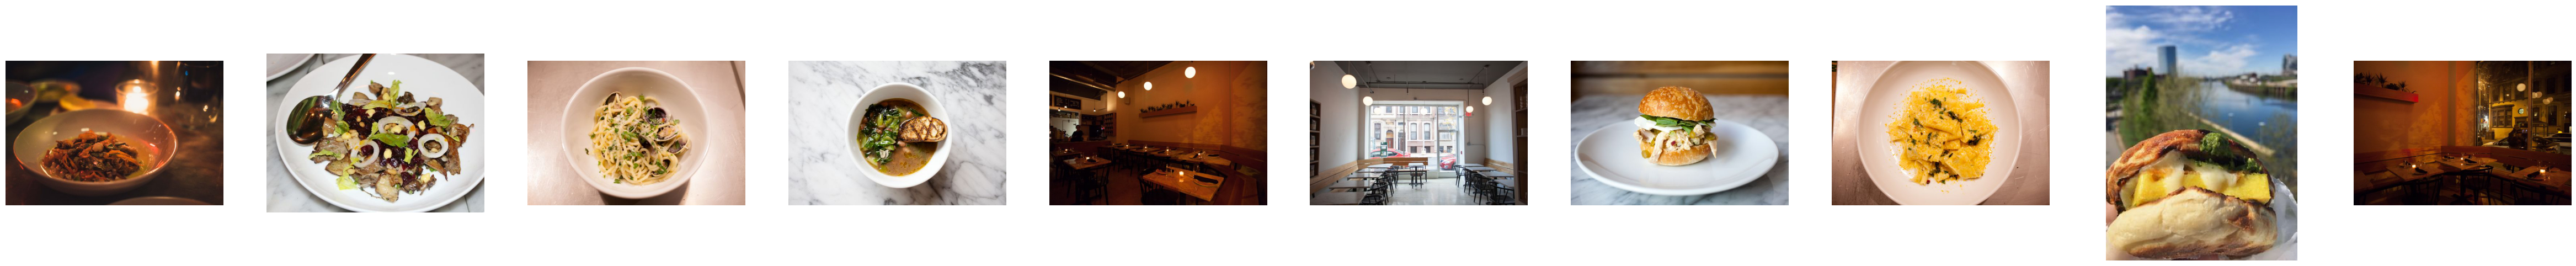

In [141]:
business_ids = list(photo_dataset.photos_by_business.keys())

if not business_ids:
    raise Exception("No business IDs found in the dataset.")

# Use the first business_id from the dataset for demonstration purposes
valid_business_id = business_ids[8]

# Get a few examples for the valid business_id
business_id, examples = photo_dataset.get_samples_for_business(valid_business_id, num_samples=10)

# for exp  in examples:
    # plt.imshow(exp)
# plt.imshow(examples[0])

print(business_id)
plt.figure(figsize=(6 * len(examples), 6))
for i, exp in enumerate(examples):
    plt.subplot(1, len(examples), i + 1)
    plt.imshow(exp)
    plt.axis('off')
plt.show()

QtST1igZAi0q9LxJr6srIQ


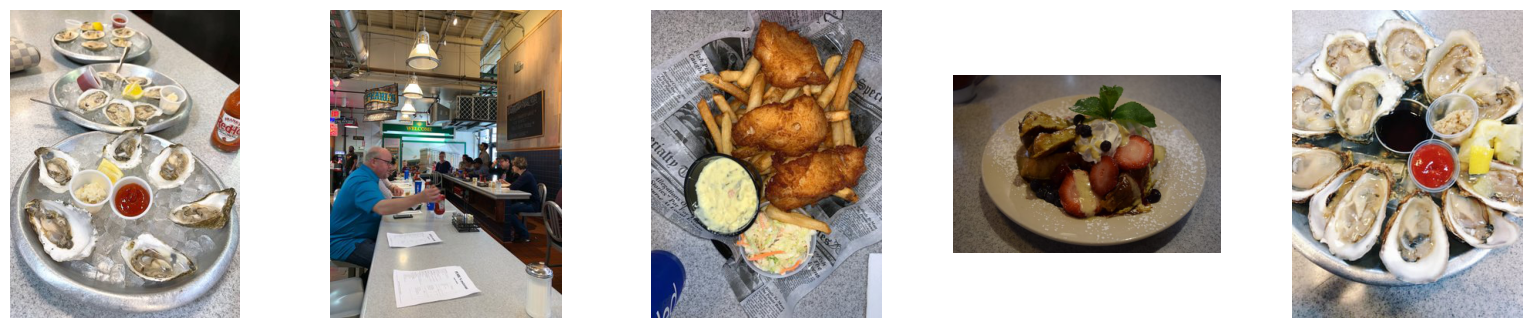

In [139]:
# Use the first business_id from the dataset for demonstration purposes
valid_business_id = business_ids[7]

# Get a few examples for the valid business_id
business_id, examples = photo_dataset.get_samples_for_business(valid_business_id, num_samples=5)

# for exp  in examples:
    # plt.imshow(exp)
# plt.imshow(examples[0])

print(business_id)
plt.figure(figsize=(4 * len(examples), 4))
for i, exp in enumerate(examples):
    plt.subplot(1, len(examples), i + 1)
    plt.imshow(exp)
    plt.axis('off')
plt.show()